In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import matplotlib.pyplot as plt
import seaborn as sb
from ggplot import *
import sklearn.cross_validation as cv
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore") 
%matplotlib inline

F:\python\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
F:\python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
F:\python\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
F:\python\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
F:\python\lib\site-packages\sklearn\cross_validati

In [2]:
# load data
projects = pd.read_csv('projects.csv')
donations = pd.read_csv('donations.csv')
outcomes = pd.read_csv('outcomes.csv')
essays = pd.read_csv('essays.csv')

## Feature selection and extraction            

There are two types of data in this project: conventional data that can be directly used, and text data from which we must extract feasible and useful features. Since I'm interested in predicting donation outcomes, I select and extract some relevant features from the conventional data and the text data           

### Conventional data

In [3]:
projects1 = projects.drop(['teacher_acctid', 'schoolid', 'school_ncesid', 'school_city',
                           'school_state', 'school_zip', 'school_metro', 'school_district',
                           'school_county'], axis=1)
projects1['year'] = pd.to_datetime(projects1['date_posted']).dt.year
projects1 = projects1[projects1['year']<2014]


outcomes1 = outcomes[['projectid', 'fully_funded']]

donations1 = donations.groupby('projectid')[['donation_to_project']].sum()
donations1.reset_index(level=0, inplace=True)

data_tidy1 = pd.merge(left = projects1, right = outcomes1, how = 'inner')
data_tidy1 = pd.merge(left = projects1, right = outcomes1, how = 'inner')
# Since some projects did not get any donnation and hence there are no records in the donation dataset, I use left join fucntion
# and convert na to 0 in terms of donation_to_project
data_tidy = pd.merge(left = data_tidy1, right = donations1, how = 'left')
data_tidy['donation_to_project'].fillna(0, inplace=True)

I also calculate the completion rate of the donation (donation_to_project / total_price_excluding_optional_support). Compared to fully_funded (binary variable), this is a better way to evaluate the donation outcome. 

In [4]:
data_tidy['completion_rate'] = data_tidy['donation_to_project'] / data_tidy['total_price_excluding_optional_support']

### Text data : Feature extraction and initial exploration        
I extract two types of features which are assumed to be relevant to donation outcomes: sentiment score and word frequency in terms of title, short description and essay. Due to the large size of text data, I determine whether they are useful for predicting outcomes through a subsample before processing the corpus.

In [5]:
# Random subsampling
essay_sub = essays.sample(n = 2000, random_state = 1)

In [6]:
# Clean the text data
essay_sub = essay_sub.replace(r'\r','', regex=True)
essay_sub = essay_sub.replace(r'\\n','', regex=True)

In [7]:
# Caculate the number of words
essay_sub['essay_num'] = essay_sub['essay'].str.split().str.len()
essay_sub['descri_num'] = essay_sub['short_description'].str.split().str.len()
essay_sub['title_num'] = essay_sub['title'].str.split().str.len()

In [8]:
# Caculate the sentiment socre
sid = SentimentIntensityAnalyzer()

essay_sub['essay_senti'] = 0
for i in range(essay_sub.shape[0]):
    essay_sub['essay_senti'].iloc[i] = sid.polarity_scores(essay_sub['essay'].iloc[i])['compound']

essay_sub['descri_senti'] = 0
for i in range(essay_sub.shape[0]):
    essay_sub['descri_senti'].iloc[i] = sid.polarity_scores(essay_sub['short_description'].iloc[i])['compound']
    
essay_sub['title_senti'] = 0
for i in range(essay_sub.shape[0]):
    essay_sub['title_senti'].iloc[i] = sid.polarity_scores(essay_sub['title'].iloc[i])['compound']

We can speculate what features can be used to predict donation outcomes (fully_funded) through a logistic regression model. 

In [9]:
data_tidy_sub = pd.merge(left = essay_sub, right = data_tidy, how = 'inner')
# fit a logistic regression
Y = data_tidy_sub['fully_funded'].apply(lambda x: 1 if x == 't' else 0)
X = data_tidy_sub[['essay_num', 'descri_num', 'title_num', 'essay_senti', 'descri_senti', 'title_senti']]
X = sm.add_constant(X)
reg = sm.Logit(Y, X, missing = 'drop')
result = reg.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.614425
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           fully_funded   No. Observations:                 1860
Model:                          Logit   Df Residuals:                     1853
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 Sep 2018   Pseudo R-squ.:                 0.01324
Time:                        17:06:36   Log-Likelihood:                -1142.8
converged:                       True   LL-Null:                       -1158.2
                                        LLR p-value:                 2.945e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.8121      0.342      5.305      0.000       1.143       2.482
essay_num       -0.0004

According to the result, we can speculate the number of title words and short description words have the potential to predict donation outcomes. So I will caculate the values in the whole dataset, and merge them into the conventional data.        

Besides, the logistic result also provides a substantial suggestion, which will be further tesed in the model section. We can find that the number of short description words have a negative correlation with fully_funded and the number of title words have a possitive correlation with it. It means longer titles and shorter descriptions predict a higher probability of fully_funded. In other words, when teachers call for donations, he/she'd better design a detailed title but a brief description to inform their needs. As for long essays, perhaps most people won't read them carefully and thus they cannot influence the final result. After all, there are a sea of projects on the website. If a project does not have a good title and a good short description, no one will further read the following essay. In addition, we have no evidence to prove the relationship between sentiment and outcomes probably because the texts of most donation projects have similar sentiments.

In [10]:
print('the number of miss value (shor description and title):')
essays[['short_description', 'title']].isnull().sum()

the number of miss value (shor description and title):


short_description    132
title                 17
dtype: int64

In [11]:
# I directly remove all observations with missing values in text data due to their extremely small percentages.
essays1 = essays[['projectid', 'short_description', 'title']].dropna()

# Since we only deal with short_description and title, we need not to clean the text
essays1['descri_num'] = essays1['short_description'].str.split().str.len()
essays1['title_num'] = essays1['title'].str.split().str.len()
    
data_tidy = pd.merge(left = essays1, right = data_tidy, how = 'inner')

## Exploration, Story and Questions: *An initial analysis of what influences completion rates*

### Projects distriution by school poverty levels                  
We can first look at the distribution of projects. Since donation projects usually have a close tie with poverty level of schools, I visualize it by color.

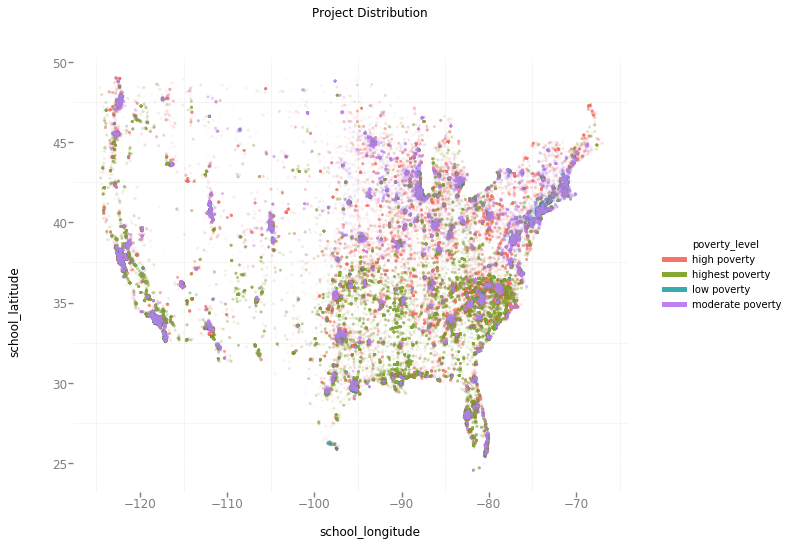

<ggplot: (144289776809)>

In [12]:
data_tidy1 = data_tidy[(data_tidy['school_longitude']>-130) & (data_tidy['school_latitude']>20)]

ggplot(aes(x='school_longitude', y='school_latitude', color='poverty_level'), data=data_tidy1) +\
    geom_point(size = 8, alpha = 0.05) +\
    theme_bw() +\
    labs(title = 'Project Distribution')

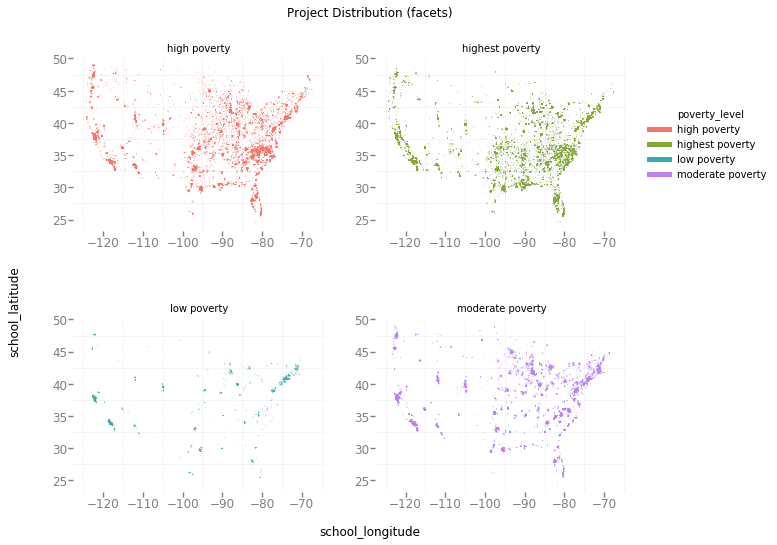

<ggplot: (-9223371892564999059)>

In [13]:
ggplot(aes(x='school_longitude', y='school_latitude', color='poverty_level'), data=data_tidy1) +\
    geom_point(size = 0.5, alpha = 0.1) +\
    facet_wrap('poverty_level') +\
    theme_bw() +\
    labs(title = 'Project Distribution (facets)')

The figures displayed above show the distribution of the projects in the contiguous United States. The overal project distribution is consistant with the population and economy distribution in the United States. Specifically, the eastern part has much more projects than the western part except the west coast (especially California), and the projects in the more economically developed northern part are more likely to come from lower poverty schools than the sourthern part. The latter phenomonen implies the unbalanced distribution of educational resource by regions.   

Besides, we should also pay attention to another phenomonen. The northeastern coast and California (probably as well as Chicago), which are the most developed areas in the United States, have substantial percentages, as well as absolute numbers, of projects from schools of all four poverty levels. It signifies the severely unbalanced distribution of educational resources within the most developed areas.

### Completion rate         
Although the raw data contains the variable of fully_funded, it does not provde enough information. In view of this, I explore the completion rate of projects rather than fully_funded. My definition of completion rate is $CR = \frac{donation\;to\;project}{total\;price\;excluding\;optional\;support}$, which is the ratio of the final donation to a project versus the dollars teachers expect to obtain.

In [14]:
print('The number of problematic observations:', len(data_tidy[data_tidy['total_price_excluding_optional_support'] == 0]))

The number of problematic observations: 305


A very small number of total_price_excluding_optional_support is zero, I directly remove them.

In [15]:
data_tidy = data_tidy[data_tidy['total_price_excluding_optional_support'] > 0]

In [16]:
data_tidy[['completion_rate', 'donation_to_project',
           'total_price_excluding_optional_support']].sort_values(by = ['completion_rate'], ascending=False).head(40)

,completion_rate,donation_to_project,total_price_excluding_optional_support
96706,404.222222,3638.00,9.00
300615,219.677778,1977.10,9.00
552027,81.819412,1390.93,17.00
545281,51.111111,460.00,9.00
516918,48.333333,435.00,9.00
263152,47.000000,423.00,9.00
376024,25.555556,230.00,9.00
333466,23.750000,403.75,17.00
201717,21.390588,363.64,17.00
240166,20.100000,341.70,17.00


There are a very small number of outliers whose completion rates are more than 3, since teachers' needs are very low and thus the donations easily become too much. I directly remove them.

In [17]:
data_tidy = data_tidy[data_tidy['completion_rate'] < 3]

Text(0,0.5,'Completion rate')

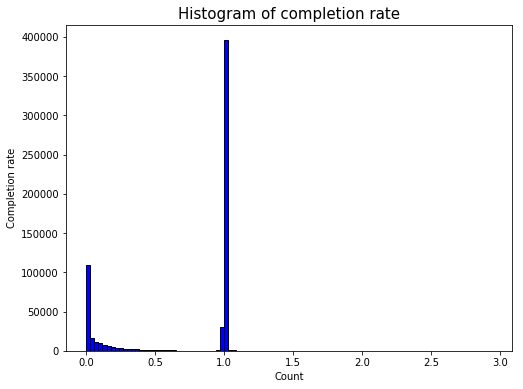

In [18]:
plt.figure(figsize=(8,6))
plt.hist(data_tidy['completion_rate'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.title('Histogram of completion rate', fontsize = 15)
plt.xlabel('Count')
plt.ylabel('Completion rate')

(0, 1.3)

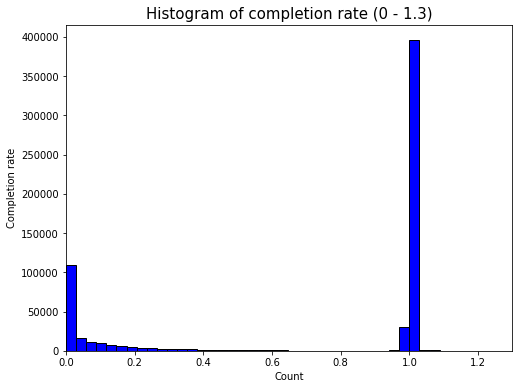

In [19]:
plt.figure(figsize=(8,6))
plt.hist(data_tidy['completion_rate'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.title('Histogram of completion rate (0 - 1.3)', fontsize = 15)
plt.xlabel('Count')
plt.ylabel('Completion rate')
plt.xlim([0, 1.3])

In [20]:
print('Proportion of 0 donation:', len(data_tidy[data_tidy['donation_to_project'] == 0]) / len(data_tidy)) 

Proportion of 0 donation: 0.1519003705241794


The histogram proves the adcantages of completion rate since the variable of fully_funded cannot well capture the "weird" distribution. First, most completion rate is around 1 and thus they are almost fully funded. However, the proportion of completion rates from 0.2 to 0.9 and over 1.1 is extremely small. In other words, most projects receive either nearly full funding or almost no funding. (The proportion of zero donation is over 0.15.). There can be two reasons for it. First, a number of projects are not reasonable in donors' opinions and thus they are not willing to donate. Second, a number of projects are not seen by other people for various reasons. Since we don't have the data of webpage hits, we could simply conditionally accept the assumption of "reasonable" and explore the data based on it. According to common senses, average amount of funding needed by school, resource type and poverty level may have the most direct influences on whether donors believe projects are reasonable. I'll take a close look at them. Besides, since the size of data is very large and thus almost all tiny differences can be significant, I don't conduct t-test or ANOVA.

In [21]:
print('The average completion rate by poverty_level\n', 
      data_tidy.groupby(['poverty_level'])['completion_rate'].mean().sort_values())
print('')
print("The average amount of needs(measured by dollars)\n", 
      data_tidy.groupby(['poverty_level'])['total_price_excluding_optional_support'].mean().sort_values())
print('')
print("The donation schools receive\n", 
      data_tidy.groupby(['poverty_level'])['donation_to_project'].mean().sort_values())

The average completion rate by poverty_level
 poverty_level
moderate poverty    0.674480
high poverty        0.685849
low poverty         0.701630
highest poverty     0.745777
Name: completion_rate, dtype: float64

The average amount of needs(measured by dollars)
 poverty_level
highest poverty     515.809542
high poverty        516.988780
moderate poverty    527.652880
low poverty         596.477771
Name: total_price_excluding_optional_support, dtype: float64

The donation schools receive
 poverty_level
high poverty        310.869500
moderate poverty    329.122661
highest poverty     336.053922
low poverty         395.731978
Name: donation_to_project, dtype: float64


At first, we can take a look at the average completion rate and the average expected fundings by poverty level. Generally, higher poverty level schools have a higher completion rate probably partly because of their lower average amount of needs. However, low poverty schools are an exception, since they need much higher average amount but still have a relatively high completion rate. Finally, they get the highest average amount of donation.

In [22]:
print('The average completion rate by resource type\n', data_tidy.groupby(['resource_type'])['completion_rate'].mean().sort_values())

# Resource_type by poverty_level
PL_RT = data_tidy.groupby(['poverty_level', 'resource_type'])[['projectid']].count()
PL_RT.reset_index(level=0, inplace=True)
PL_RT.reset_index(level=0, inplace=True)
PL_RT = PL_RT.pivot(index='resource_type',columns='poverty_level',values='projectid')
for i in range(4):
    PL_RT.iloc[:,i] = PL_RT.iloc[:,i] / PL_RT.sum(axis = 0)[i]
print('\n\nThe proportion of resource_type:')
PL_RT


The average completion rate by resource type
 resource_type
Technology    0.642824
Visitors      0.686204
Other         0.714097
Trips         0.743857
Supplies      0.752443
Books         0.782587
Name: completion_rate, dtype: float64


The proportion of resource_type:


poverty_level,high poverty,highest poverty,low poverty,moderate poverty
resource_type,,,,
Books,0.209705,0.227579,0.182939,0.190619
Other,0.105517,0.105142,0.091404,0.104472
Supplies,0.334334,0.360362,0.300374,0.315661
Technology,0.343816,0.295538,0.417743,0.384366
Trips,0.005281,0.009765,0.006164,0.003773
Visitors,0.001347,0.001615,0.001377,0.001110


For the resource type, low poverty schools are also the exception. The needs for books, supplies and trips have relatively higher completion rate and the needs for technology have the lowest completion rate. It makes sense because books and supplies are the necessities or the most urgent items for schools and students, and technology is not. However, when we consider the conditional proportion by poverty level, low poverty school is still the exception. They have really high needs for technology and the lowest needs for books and supplies, but still has the second highest completion rate. Given technology is usually more expansive than books and basic supplies, the tables here also explain why students in low poverty schools need the highest average amount of funding. Undoubtly  there must be other factors that influence the result.


In summary, average amount of funding needed by school, resource type and poverty level are very likely to influence completion rate according to the initial exploration. However, low poverty schools are always the exception. Because most low poverty school are located at the most developed area such as the northeastern part and California (see the first two figures), we can speculate that their relatively more fruitful resurces help them further get more resources. For example, their better skill of using the Internet and their familiarity with online donation environments probably increase the completion rates of donation. Although we need more evidence to prove it, the data has suggested that the current resource distribution in terms of donation is not good enough since low poverty school get much more resources.   

### Questions for the Project Partner and other data          
1. I'm wondering how the poverty level is defined. Is it based on federal standard, state standard or just self-reported? The answer can heavily influence how we explain or question the data.         
2. Is there a dataset of the numbers of hits of project webpage. It is very useful for us to determine why some projects receive nearly no funding. It can also be combined with natural language processing methods to help teachers write appropriate titles, short descriptions and essays.      
3. I believe we'd better further combine datasets about population distribution and socioeconomic & educational resource distribution to explain the unblanced resource distribution across regions as well as across poverty levels. These types of data can answer why low poverty schools are always the exception.

## Modeling             

For pure prediction tasks related structured data, gradient boosting tree is the most widely used method and usually with the highest perdictive performance since 2016. However, its results cannot be well interpreted. The best way, at least for me, is to build a highly interpretive model as well as a highly predictive model. However, since the exercise only requires one model, I choose to build a lasso model since it is highly interpretive, usually has good predictive performance and can directly select features.

### Clean data for modeling

In [23]:
# Check missing value
data_tidy.drop(['fully_funded', 'primary_focus_subject', 'secondary_focus_subject', 
                'date_posted', 'projectid', 'short_description', 'title'], axis = 1).isnull().sum()

descri_num                                     0
title_num                                      0
school_latitude                                0
school_longitude                               0
school_charter                                 0
school_magnet                                  0
school_year_round                              0
school_nlns                                    0
school_kipp                                    0
school_charter_ready_promise                   0
teacher_prefix                                 0
teacher_teach_for_america                      0
teacher_ny_teaching_fellow                     0
primary_focus_area                            35
secondary_focus_area                      193537
resource_type                                 42
poverty_level                                  0
grade_level                                    6
fulfillment_labor_materials                34671
total_price_excluding_optional_support         0
total_price_includin

In [24]:
# Remove columns with too many missing values and then remove rows with missing values
# Caculate optional_support
model_data = data_tidy.drop(['fully_funded', 'primary_focus_subject', 'secondary_focus_subject', 'date_posted',
                             'secondary_focus_area', 'fulfillment_labor_materials', 'projectid', 'donation_to_project', 
                             'short_description', 'title', 'school_latitude', 'school_longitude'], axis = 1).dropna()
model_data['optional_support'] = model_data['total_price_including_optional_support'] - model_data['total_price_excluding_optional_support']
model_data = model_data.drop(['total_price_including_optional_support'], axis = 1)

In [25]:
# Check variable type
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618677 entries, 0 to 619177
Data columns (total 22 columns):
descri_num                                618677 non-null int64
title_num                                 618677 non-null int64
school_charter                            618677 non-null object
school_magnet                             618677 non-null object
school_year_round                         618677 non-null object
school_nlns                               618677 non-null object
school_kipp                               618677 non-null object
school_charter_ready_promise              618677 non-null object
teacher_prefix                            618677 non-null object
teacher_teach_for_america                 618677 non-null object
teacher_ny_teaching_fellow                618677 non-null object
primary_focus_area                        618677 non-null object
resource_type                             618677 non-null object
poverty_level                             6186

In [26]:
# Convert variable type
## Since lasso function cannot deal with categorical features, I use one hot encoding to covert them
## Convert dummy features
for i in [2,3,4,5,6,7,9,10,17,18]:
    model_data.iloc[:,i] = model_data.iloc[:,i].apply(lambda x: 1 if x == 't' else 0)
## Convert multi-categorical features
for feature in model_data.columns:
    if model_data[feature].dtype == 'object':
        X_ = pd.get_dummies(model_data[feature])
        model_data = pd.concat([model_data, X_], axis = 1).drop([feature], axis = 1)

### Build a lasso model

In [27]:
# I select the data in the year of 2013 as the testing set
data_test = model_data[model_data['year'] == 2013]
data_train = model_data[model_data['year'] < 2013]

In [28]:
y_train = data_train['completion_rate']
X_train = data_train.drop(['completion_rate'], axis = 1)
y_test = data_test['completion_rate']
X_test = data_test.drop(['completion_rate'], axis = 1)

In [29]:
# Use LassoCV to find the optimal alpha(lambda) through 5-fold cross validation
lasso = Lasso(max_iter=10000, normalize=True)
lassocv = LassoCV(alphas=None, cv=5, max_iter=10000, normalize=True)
lassocv.fit(X_train, y_train)
# Fit a lasso model with the optimal alpha
print('Alpha =', lassocv.alpha_)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
# Calculate the mean squared error though the testing set and list the coefficients
print('mse = ',mean_squared_error(y_test, lasso.predict(X_test)))
print('intercept =', lasso.intercept_)
print('\nbest model coefficients:')
pd.Series(lasso.coef_, index=model_data.drop(['completion_rate'],1).columns)

Alpha = 7.703443022327569e-08
mse =  0.17314752579776316
intercept = -11.801180876525978

best model coefficients:


descri_num                               -3.929457e-03
title_num                                 2.818974e-03
school_charter                            2.648304e-02
school_magnet                             1.293907e-02
school_year_round                        -2.379463e-03
school_nlns                               5.143774e-02
school_kipp                               1.469563e-02
school_charter_ready_promise              3.244972e-02
teacher_teach_for_america                 9.482986e-02
teacher_ny_teaching_fellow                7.609904e-02
total_price_excluding_optional_support   -2.046554e-04
students_reached                         -3.802843e-07
eligible_double_your_impact_match         8.185634e-02
eligible_almost_home_match                9.837840e-02
year                                      6.288569e-03
optional_support                          8.891103e-04
Dr.                                       2.541041e-01
Mr.                                       2.743472e-03
Mr. & Mrs.

Text(0.5,1,'Coefficients of the lasso model')

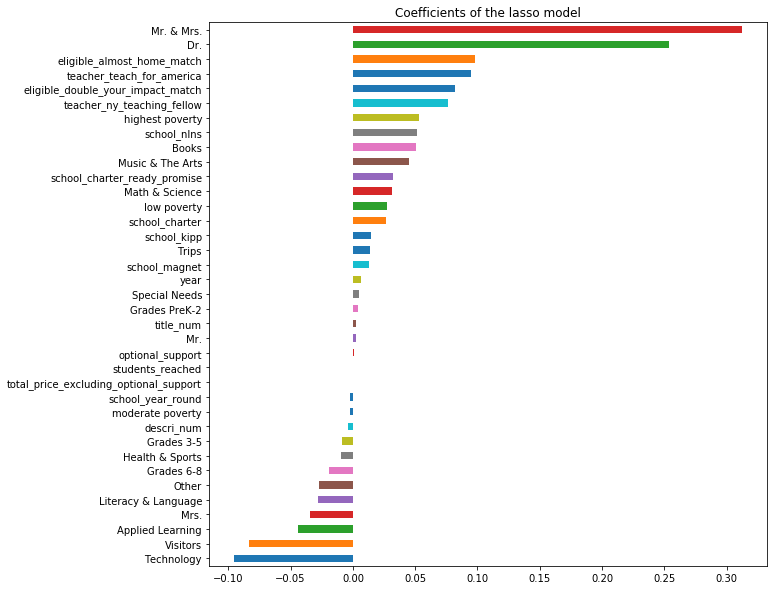

In [30]:
plt.figure(figsize=(10,10))
v_coef = pd.Series(lasso.coef_, index=model_data.drop(['completion_rate'],1).columns).sort_values()
v_coef[v_coef!=0].plot(kind = 'barh')
plt.title('Coefficients of the lasso model')

Lasso does not remove any features. Although there are some coefficients are 0, it is exactly derived from the one hot encoding in python whose packages usually cannot deal with multi-categorical features.            

For the types of feature coefficients, we can divided them into several groups: characteristics of teachers who call for projects, essay quality and quantity, characteristics of schools, characteristics of resource needed by students/teachers and beneficial policies. Among them, variables belonging to characteristics of teachers seemingly have the largest combined influence and/or the strongest combined correlation with the final completion rate because most of their coefficients have large magnitudes. (It is worth noting that most features in the model are dummy so that we can compare the magnitudes. Some continuous features will be mentioned later). Teachers with good characterisitcs, such as doctor's degree and plural experience related to gender identification and teaching fellowship, overally have larger positive magnitudes. Compared to their colleagues, they may have more social and cultural capitals, as well as skills, and thus better know how to make their projects successful. As for essay quality and quantity, the result confirms the result in feature extraction section that longer titles and shorter description predict higher completion rate. Characteristics of resource don't have enough combined predictive power as expected. Specifically, they only have moderate magnitudes, and the relationship between them and donation outcomes are similar to the results in the data exploration section. As for continuous features regarding resource types such as total price of items that schools need, even though we consider their scales, the scaled magnitudes seem just up to moderate. Characterisitcs of schools are similar to those of resources. Finally, as for beneficial policies such as boost offer, there is no doubt that they have big positive magnitudes.       

The results in the data exploration section and the modeling section provide us with two very important public policy suggestions if we want to make resource more balanced. First, governments should help poverty schools to hire more good teachers through policy supports since the data shows the importance of teacher quality at least in donation projects. Second, company should give higher poverty schools more beneficial policy to further increase their completion rate. In addition, the features extracted from the text data and the features regarding resource type are also potentially useful for teachers. They can select resource types, adjust total prices and write detailed titles with brief discriptions to increase completion rates. 

